# Temporal sequence classification: CROHME dataset

Dataset:
https://www.cs.rit.edu/~rlaz/files/CROHME+TFD%E2%80%932019.pdf

Objective: 

- Recognize handwriting input sequences (mathematical expression)
- Output sequence of symbols + relations based on Symbol Relation Tree and Writing Order

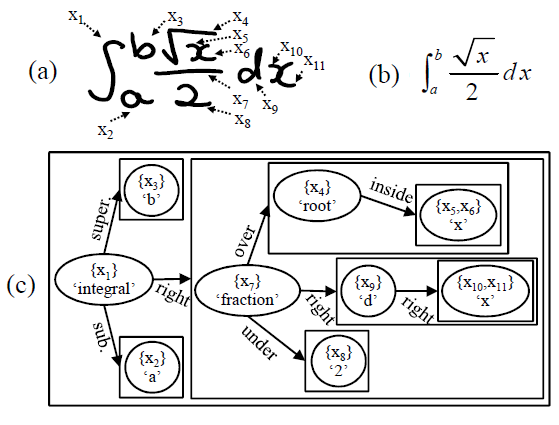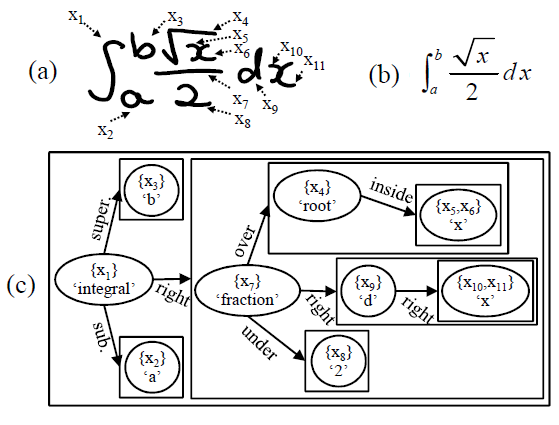

Method:
- Use recurrent neural networks (Bi-directional LSTM).
- Training: supervised learning using pairs of input sequence and target sequence.
- Loss function: CTC loss function to learn temporal classification.
https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html


## Task 1: Dataset & Dataloader (3 pts)

### Overview

We need to build the Dataset class which read the input samples, annotation files and return the pair of <input, target> for each sample.

The target should follow the description of CTC loss function. "Each element in the target sequence is a class index".

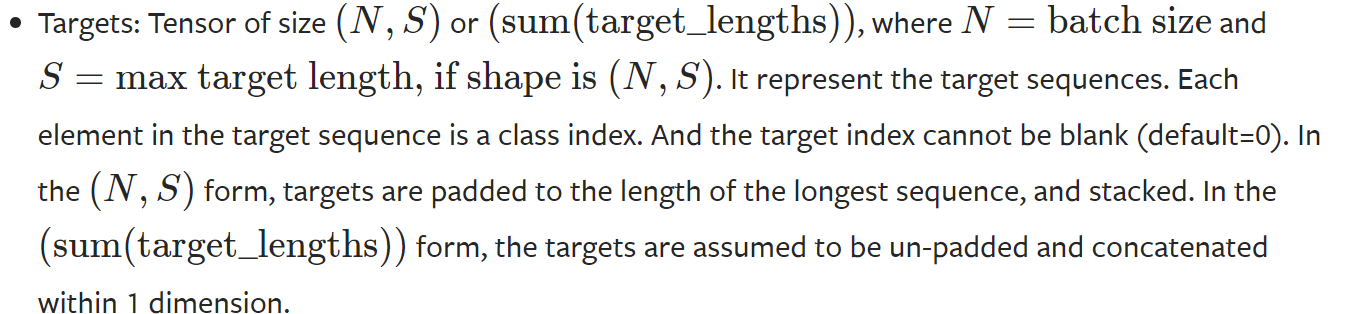


Example:

We have an inkml file: "crohme2019/test/UN19_1041_em_597.inkml"	
Its label is "- Right \sqrt Inside 2"

Target would be: [[5, 50, 35, 51, 12]], where the index here is the index of tokens (from a vocabulary)


### Task 1.1 Build vocab

The first task is build the vocabulary from the dataset. From the target of the annotation files, extract and unique the token list to get the vocabulary. (Find the set of symbols and relations from labeled dataset).

Input: 

```
/kaggle/input/crohme2019/crohme2019_train.txt
/kaggle/input/crohme2019/crohme2019_valid.txt
/kaggle/input/crohme2019/crohme2019_test.txt
```
Output:
```
crohme_vocab.txt
```

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("ntcuong2103/crohme2019")

print("Path to dataset files:", path)

In [1]:
input_files = ['/kaggle/input/crohme2019/crohme2019_train.txt',
'/kaggle/input/crohme2019/crohme2019_valid.txt',
'/kaggle/input/crohme2019/crohme2019_test.txt']

vocab = set()

for input_file in input_files:
    for line in open(input_file).readlines():
        if len(line.strip().split('\t')) == 2:
            vocab.update(line.strip().split('\t')[1].split())


In [2]:
vocab_syms = [v for v in vocab if v not in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']]

In [3]:
with open('crohme_vocab.txt', 'w') as f:
    f.writelines([c + '\n' for c in sorted(vocab_syms)])
    f.writelines([c + '\n' for c in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']])

#### Vocab class

In [4]:
class Vocab(object):
    def __init__(self, vocab_file=None):
        self.word2index = {}
        self.index2word = {}

        if vocab_file:
            self.load_vocab(vocab_file)
    
    def load_vocab(self, vocab_file):
        # load vocab from file
        with open(vocab_file, 'r') as f:
            for i, line in enumerate(f):
                word = line.strip()
                self.word2index[word] = i
                self.index2word[i] = word
        # add blank word
        self.word2index['<blank>'] = len(self.word2index)
        self.index2word[self.word2index['<blank>']] = '<blank>'


In [5]:
vocab = Vocab(vocab_file = '/kaggle/working/crohme_vocab.txt')

In [6]:
vocab.index2word

{0: '!',
 1: '(',
 2: ')',
 3: '+',
 4: '-',
 5: '.',
 6: '/',
 7: '0',
 8: '1',
 9: '2',
 10: '3',
 11: '4',
 12: '5',
 13: '6',
 14: '7',
 15: '8',
 16: '9',
 17: '=',
 18: 'A',
 19: 'B',
 20: 'C',
 21: 'COMMA',
 22: 'E',
 23: 'F',
 24: 'G',
 25: 'H',
 26: 'I',
 27: 'L',
 28: 'M',
 29: 'N',
 30: 'P',
 31: 'R',
 32: 'S',
 33: 'T',
 34: 'V',
 35: 'X',
 36: 'Y',
 37: '[',
 38: '\\Delta',
 39: '\\alpha',
 40: '\\beta',
 41: '\\cos',
 42: '\\div',
 43: '\\exists',
 44: '\\forall',
 45: '\\gamma',
 46: '\\geq',
 47: '\\gt',
 48: '\\in',
 49: '\\infty',
 50: '\\int',
 51: '\\lambda',
 52: '\\ldots',
 53: '\\leq',
 54: '\\lim',
 55: '\\log',
 56: '\\lt',
 57: '\\mu',
 58: '\\neq',
 59: '\\phi',
 60: '\\pi',
 61: '\\pm',
 62: '\\prime',
 63: '\\rightarrow',
 64: '\\sigma',
 65: '\\sin',
 66: '\\sqrt',
 67: '\\sum',
 68: '\\tan',
 69: '\\theta',
 70: '\\times',
 71: '\\{',
 72: '\\}',
 73: ']',
 74: 'a',
 75: 'b',
 76: 'c',
 77: 'd',
 78: 'e',
 79: 'f',
 80: 'g',
 81: 'h',
 82: 'i',
 83: 'j',


In [7]:
## test vocab
vocab = Vocab('crohme_vocab.txt')
input = '- Right \\sqrt Inside 2'.split()
output = [vocab.word2index[word] for word in input]
output
assert output == [4, 105, 66, 103, 9]

### Task 1.2: Write dataset class

In this task, we will build a dataset class that will be used to load the dataset files _(train, valid, and test)_.

The dataset class will also be used to preprocess the data by converting the characters in the data to integers using the vocabulary.

> _Before going to this task, it is **highly recommended** to read this [Tutorial on creating Custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) with PyTorch._
>
> _You should have basic understanding of required methods in the Dataset class such as `__init__`, `__len__`, and `__getitem__`._


***Input***: Dataset class should take the following arguments:.

- `annotation`: the path to the dataset annotation *(`.txt`)*.
- `root_dir`: the root directory of the dataset file.
- `vocab`: the vocabulary.

***Output***: the dataset class.

> *Note: You can adjust the Dataset class base on your references.*


#### How to handle an InkML files 

Visualize InkML file
https://www.cs.rit.edu/~rlaz/inkml_viewer/index.xhtml


Below is a class structure for handling `.inkml` files.

In [8]:
import numpy as np

import xml.etree.ElementTree as ET

class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""
    __slots__ = ('id', 'label' ,'strId')
    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])

class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""
    __slots__ = ('fileName', 'strokes', 'strkOrder','segments','truth','UI')

    NS = {'ns': 'http://www.w3.org/2003/InkML', 'xml': 'http://www.w3.org/XML/1998/namespace'}

    def __init__(self,*args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()
    
    def fixNS(self,ns,att):
        """Build the right tag or element name with namespace"""
        return '{'+Inkml.NS[ns]+'}'+att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall('ns:annotation',namespaces=Inkml.NS):
            if 'type' in info.attrib:
                if info.attrib['type'] == 'truth':
                    self.truth = info.text.strip()
                if info.attrib['type'] == 'UI':
                    self.UI = info.text.strip()
        for strk in root.findall('ns:trace',namespaces=Inkml.NS):
            self.strokes[strk.attrib['id']] = strk.text.strip()
            self.strkOrder.append(strk.attrib['id'])
        segments = root.find('ns:traceGroup',namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in (segments.iterfind('ns:traceGroup',namespaces=Inkml.NS)):
            id = seg.attrib[self.fixNS('xml','id')]
            label = seg.find('ns:annotation',namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall('ns:traceView',namespaces=Inkml.NS):
                strkList.add(t.attrib['traceDataRef'])
            self.segments[id] = Segment(id,label, strkList)
        
    def getTraces(self, height = 256):
        traces_array = [np.array([p.strip().split() 
            for p in self.strokes[id].split(',')], dtype='float') 
              for id in self.strkOrder ]
        
        ratio = height / ((np.concatenate(traces_array, 0).max(0) - np.concatenate(traces_array, 0).min(0))[1] + 1e-6)
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

`Inkml` class is used to read an inkml file and extract the strokes

***Input***: the path to the inkml file.

***Output***: Inkml object that can be used to extract the strokes.

#### Visualize InkML traces

> The coordinations of pen traces (x, y) are obtain from collection device, origin at top left position. To visualize, the y coordination need to be inverted.

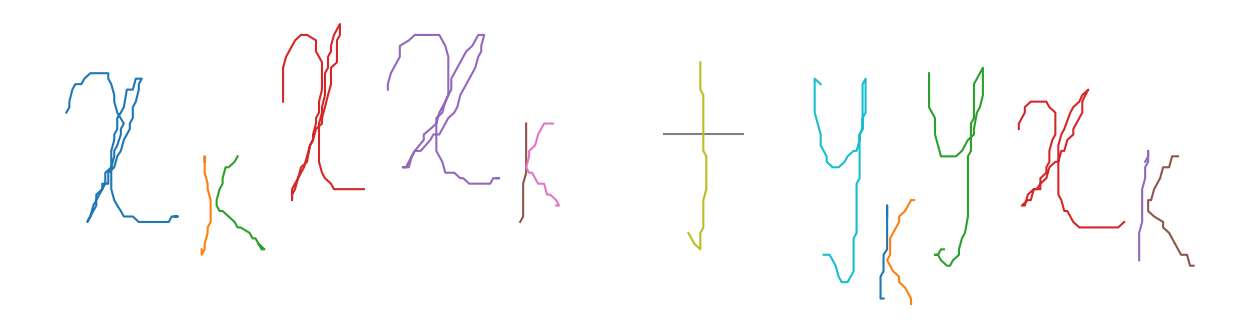

In [9]:
import matplotlib.pyplot as plt

def visualize_inkml(ink_obj: Inkml):
    ink = ink_obj

    plt.figure(figsize=(16, 4))
    plt.axis("off")
    for trace in ink.getTraces():
        trace_arr = np.array(trace)
        plt.plot(trace_arr[:, 0], -trace_arr[:, 1])  # invert y coordinate


path = '/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml'
ink = Inkml(path)
visualize_inkml(ink)

> **TASK: UNDERSTAND AND HANDLE OUTPUT OF `getTraces()` METHOD IN `Inkml` CLASS.**



In [10]:
# ink object from an InkML file
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')

# get traces from the ink object
[np.array(trace).shape for trace in ink.getTraces()]

[(525, 2),
 (113, 2),
 (118, 2),
 (328, 2),
 (350, 2),
 (96, 2),
 (130, 2),
 (115, 2),
 (293, 2),
 (304, 2),
 (111, 2),
 (133, 2),
 (265, 2),
 (329, 2),
 (103, 2),
 (132, 2)]

**WARNING**: _Some Inkml may return (x, y, t) coordinates, while others may return (x, y) coordinates. Make sure to handle this in your implementation._

Now you have the idea of how to read an inkml file, let's build the Dataset class.

#### Build Dataset

Base on the observation, how can we build a dataset class from the dataset files?

***Hints:***
   - *Understand the big picture. (Data --> Dataset --> DataLoader --> Model --> Output --> Calculate Loss --> Backpropagation --> Update weight)*
   - *What do our model expect to get? In other words, what information is being fed into our model to calculate the loss?*
   - *What informations needed to calculate our Loss?*
   - *What should be returned in the `__getitem__` method?*
   - *The outputs should be of Tensor type*
   
***References from pytorch tutorials***

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- \_\_len\_\_ so that len(dataset) returns the size of the dataset.

- \_\_getitem\_\_ to support the indexing such that dataset[i] can be used to get ith sample.


> **TASK: IMPLEMENT `InkmlDataset` CLASS.**

You need to complete the implementation of InkMmlDataset class. Check out the sub-tasks for more information.

In [11]:
import os
import torch
import math
import numpy as np
from torch.utils.data import Dataset

class InkmlDataset(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): Path to the annotation file.
            root_dir (string): Directory with all the inkml files.
            vocab (object): Vocabulary object with word2index mapping.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab
        
        # Load annotations
        self.ink_paths = []
        self.labels = []
        self._load_annotations()

    def _load_annotations(self):
        """
        Load ink paths and labels from the annotation file.
        """
        try:
            with open(self.annotation, 'r') as file:
                for line in file:
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        ink_path, label = parts
                        self.ink_paths.append(os.path.join(self.root_dir, ink_path))
                        self.labels.append(label.split())
        except Exception as e:
            print(f"Error reading annotation file: {e}")

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Return the idx-th sample in the dataset.
        """
        inkfile = self.ink_paths[idx]
        label = self.labels[idx]

        # Read inkml sample --> traces
        ink = Inkml(inkfile)
        traces = ink.getTraces()
        
        # Remove consecutive duplicated points
        traces = [self._remove_duplicate(trace) for trace in traces]
        
        # Extract features (delta_x / distance, delta_y / distance, distance, pen_up)
        feature = self._feature_extraction(traces)
        
        # Convert tokens of label into vocab indexes
        label = torch.tensor([self.vocab.word2index[word] for word in label], dtype=torch.long)
        
        input_len = torch.tensor(len(feature), dtype=torch.long)
        label_len = torch.tensor(len(label), dtype=torch.long)
        
        return feature, label, input_len, label_len
    
    def _remove_duplicate(self, trace):
        """
        Remove consecutive duplicated points in a trace.
        """
        if not trace:
            return trace
        new_trace = [trace[0]]
        cur = trace[0]
        for point in trace[1:]:
            if point != cur:
                new_trace.append(point)
                cur = point
        return new_trace

    def _feature_extraction(self, traces):
        """
        Extract features from traces.
        """
        feature = []
        for i, trace in enumerate(traces):
            for j, point in enumerate(trace):
                if j == 0:
                    if i == 0:
                        continue
                    prev_point = traces[i - 1][-1]
                else:
                    prev_point = trace[j - 1]

                dX = point[0] - prev_point[0]
                dY = point[1] - prev_point[1]
                d = math.sqrt(dX**2 + dY**2)
                pen_up = int(j == 0 and i != 0)
                
                if d != 0:
                    feature.append([dX / d, dY / d, d, pen_up])
        
        return torch.tensor(feature, dtype=torch.float)

#### Feature representation

In this subtask, we will convert the strokes into feature representations that can be used by the model.

Initially, the `.getTraces()` method returns list of strokes, where each stroke is a list of (x, y) coordinates. Intuitively, we can use those coordinates as features. But if we directly use the coordinates, the model will have a hard time learning the patterns.

Instead, we can calculate the difference *(∆d)* between consecutive coordinates as features. This way, the model can learn the patterns more easily.
The feature could also be normalize as ($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$, $d$), where $d = \sqrt{\Delta_x^2 + \Delta_y^2}$

**Pen-up and Pen-down**

In the dataset, each stroke is separated by a pen-up event. We can use this information to separate the strokes.

1. The pen is lifted from the paper (connecting the end of a stroke to the start of a stroke): $pen\_up = 1$
2. The pen is on the paper: $pen\_up = 0$ 

Then, our feature representation would be:
($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$, $d$, $pen\_up$)


```
point 1: (x1, y1)
point 2: (x2, y2)
point 3: (x3, y3) <--- end of stroke #1
point 4: (x4, y4) <--- start of stroke #2
...
point n: (xn, yn)
```

The feature representation will be:

```
f1 = ((x2 - x1) / d, (y2 - y1)/d, d, 0)
f2 = ((x3 - x2) / d, (y3 - y2)/d, d, 0)
f3 = ((x4 - x3) / d, (y4 - y3)/d, d, 1) <-- pen up
...
fn-1 = ((xn - xn-1) / d, (yn - yn-1)/d, d, 0)
```

> **Subtask: REMOVE DUPLICATED POINTS.**

In [12]:
def remove_duplicate(trace):
    """
    Remove consecutive duplicated points in a trace.

    Arguments:
        trace (list): List of points, where each point is a tuple or list of coordinates.

    Returns:
        list: List of points with consecutive duplicates removed.
    """
    if not trace:
        return trace
    
    new_trace = [trace[0]]
    for point in trace[1:]:
        if point != new_trace[-1]:
            new_trace.append(point)
    
    return new_trace

> **Test your implementation**

In [13]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]

assert list(map(len,traces)) == [82, 16, 21, 78, 82, 15, 18, 18, 28, 58, 15, 19, 56, 70, 18, 21]

> **Subtask: CALCULATE `(∆X / d, ∆Y /d, d)` FOR INPUT FEATURE.**

In [14]:
import math
import numpy as np

def feature_extraction(traces):
    """
    Extract features from traces.

    Arguments:
        traces (list): List of traces, where each trace is a list of points (tuples or lists of coordinates).

    Returns:
        np.ndarray: Extracted features as a numpy array of shape (num_features,).
    """
    feature = np.empty([0, 3])
    
    for i in range(len(traces)):
        for j in range(len(traces[i])):
            if j == 0:
                if i == 0:
                    continue
                dX = traces[i][j][0] - traces[i-1][len(traces[i-1])-1][0]
                dY = traces[i][j][1] - traces[i-1][len(traces[i-1])-1][1]
                d = math.sqrt(math.pow(dX, 2) + math.pow(dY, 2))
            else:
                dX = traces[i][j][0] - traces[i][j-1][0]
                dY = traces[i][j][1] - traces[i][j-1][1]
                d = math.sqrt(math.pow(dX, 2) + math.pow(dY, 2))
            
            if d != 0:
                delta_x_norm = dX / d
                delta_y_norm = dY / d
            else:
                delta_x_norm = 0.0
                delta_y_norm = 0.0

            feature = np.append(feature, np.array([[delta_x_norm, delta_y_norm, d]]), axis=0)

    return feature

> **Test your implementation**

In [15]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]
feature = feature_extraction(traces)

import numpy.testing as npt
assert feature.shape == (614, 3)
npt.assert_allclose(feature.mean(axis=0), np.array([ 0.17677799,  0.29519369, 11.35540311]))
npt.assert_allclose(feature.var(axis=0), np.array([3.75390418e-01, 5.06219812e-01, 4.19017361e+02])
)

> **Subtask: CALCULATE `(∆X / d, ∆Y /d, d, pen_up)` FOR INPUT FEATURE.**

In [16]:
import math
import numpy as np

def feature_extraction(traces):
    """
    Extract features from traces.

    Arguments:
        traces (list): List of traces, where each trace is a list of points (tuples or lists of coordinates).

    Returns:
        np.ndarray: Extracted features as a numpy array of shape (num_features, 4).
    """
    feature = np.empty([0, 4])
    
    for i in range(len(traces)):
        for j in range(len(traces[i])):
            if j == 0:
                if i == 0:
                    continue
                dX = traces[i][j][0] - traces[i-1][-1][0]
                dY = traces[i][j][1] - traces[i-1][-1][1]
                d = math.sqrt(dX ** 2 + dY ** 2)
            else:
                dX = traces[i][j][0] - traces[i][j-1][0]
                dY = traces[i][j][1] - traces[i][j-1][1]
                d = math.sqrt(dX ** 2 + dY ** 2)
            
            if d != 0:
                delta_x_norm = dX / d
                delta_y_norm = dY / d
            else:
                delta_x_norm = 0.0
                delta_y_norm = 0.0

            pen_up = int(j == 0 and i != 0)

            feature = np.append(feature, [[delta_x_norm, delta_y_norm, d, pen_up]], axis=0)

    return feature

> **Test your implementation**

In [17]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]
feature = feature_extraction(traces)

import numpy.testing as npt
assert feature.shape == (614, 4)
npt.assert_array_equal(np.where(feature[:,3] == 1)[0], np.array([ 81,  97, 118, 196, 278, 293, 311, 329, 357, 415, 430, 449, 505,
       575, 593]))


> **Subtask: COMPLETE InkmlDataset class**

From the sub-tasks, complete the implementation of InkmlDataset class.

> **Test your implementation**

In [18]:
dataset = InkmlDataset(annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', root_dir='/kaggle/input/crohme2019/crohme2019', vocab=Vocab('crohme_vocab.txt'))
feature, label, input_len, label_len = dataset.__getitem__(0)

import numpy.testing as npt

assert type(feature) == torch.Tensor
assert type(label) == torch.Tensor
assert feature.shape == (231, 4)
npt.assert_array_equal(label, np.array([59, 105, 1, 105, 59, 105, 1, 105, 87, 105, 2, 105, 2]))
assert input_len == 231
assert label_len == 13

### Dataloader

Write the dataloader with custom collate function to pad the input and target sequence

Reference:
https://colab.research.google.com/drive/1TS7kIuNwYIN2dYGIzm-60hPnmYxKi-VN?usp=sharing
https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [19]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """Create batch with padded sequences."""
    if not batch:
        raise ValueError("Received an empty batch.")
    
    # Separate features and labels from batch
    features = [data[0] for data in batch if data[0].nelement() > 0]
    labels = [data[1] for data in batch if data[1].nelement() > 0]

    if len(features) != len(batch) or len(labels) != len(batch):
        raise ValueError("One or more sequences in the batch are empty.")

    # Calculate lengths of each sequence
    input_lens = torch.as_tensor([len(feature) for feature in features])
    label_lens = torch.as_tensor([len(label) for label in labels])

    # Pad sequences to the same length
    features = pad_sequence(features, batch_first=True)
    labels = pad_sequence(labels, batch_first=True)

    # Return tensors
    return features, labels, input_lens, label_lens

In [20]:
features, labels, input_lens, label_lens = collate_fn([dataset[0], dataset[1]])

import numpy.testing as npt

assert type(input_lens) == torch.Tensor
assert type(label_lens) == torch.Tensor

assert features.shape == (2, 231, 4)
assert labels.shape == (2, 13)
npt.assert_array_equal(input_lens.numpy(), np.array([231, 102])) 
npt.assert_array_equal(label_lens, np.array([13, 5]))

In [21]:
# test collate_fn with data loader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

features, labels, input_lens, label_lens = next(iter(data_loader))
assert features.shape == (2, 231, 4)
assert labels.shape == (2, 13)
npt.assert_array_equal(input_lens.numpy(), np.array([231, 102])) 
npt.assert_array_equal(label_lens, np.array([13, 5]))

### Pytorch lightning datamodule

https://lightning.ai/docs/pytorch/stable/data/datamodule.html

#### Data module

In [22]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class CROHMEDatamodule(pl.LightningDataModule):
    def __init__(self, root_dir, train_annotation, validation_annotation, test_annotation, vocab_file, batch_size, num_workers):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.train_annotation = train_annotation
        self.validation_annotation = validation_annotation
        self.test_annotation = test_annotation
        self.vocab = Vocab(vocab_file)
        self.num_workers=num_workers

    def setup(self, stage: str):
        self.train_dataset = InkmlDataset(self.train_annotation, self.root_dir, self.vocab)
        self.val_dataset = InkmlDataset(self.validation_annotation, self.root_dir, self.vocab)
        self.test_dataset = InkmlDataset(self.test_annotation, self.root_dir, self.vocab)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, collate_fn=collate_fn)

## Task 2: Models, loss functions (2 pts)

### Model

Check out this tutorial
https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

In [23]:
# build a model of Bidirectional LSTM 3 x 128
import torch.nn as nn
class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # declare layers
        super(LSTM_TemporalClassification, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        # Pass through LSTM layer
        x, (h_n, c_n) = self.lstm(x)
        # Apply fully connected layer to each time step's output
        x = self.fc(x)

        return x

In [24]:
# test your implementation
model = LSTM_TemporalClassification(4, 128, 3, 109)
assert model.forward(torch.rand((10, 100, 4))).shape == (10, 100, 109)

### Loss: CTC

Read the documentation of CTC loss
https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html

What is the role of `input_lengths`, `target_lengths`

```
loss = nn.CTCLoss()(input, target, input_lengths, target_lengths)
```

### Pytorch lightning Module

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

A LightningModule organizes your PyTorch code into 6 sections:

Initialization (\_\_init\_\_ and setup()).

Train Loop (training_step())

Validation Loop (validation_step())

Test Loop (test_step())

Optimizers and LR Schedulers (configure_optimizers())


> **Task: Complete the LightningModule**

- Calculate loss
- Log the loss

In [25]:
import pytorch_lightning as pl
import torch

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers=3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.CTCLoss(blank=output_size - 1)
        self.lr = lr
        self.decoder = decoder
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)
                    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)

        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

## Task 3: Training with Trainer (pytorch lightning) (2 pts)

Pytorch lightning trainer:
https://lightning.ai/docs/pytorch/stable/common/trainer.html

From the documentation:

> The Lightning Trainer does much more than just “training”. Under the hood, it handles all loop details for you, some examples include:
> - Automatically enabling/disabling grads
> - Running the training, validation and test dataloaders
> - Calling the Callbacks at the appropriate times
> - Putting batches and computations on the correct devices

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_loss:.4f}', save_top_k=5, monitor='val_loss', mode='min'),
    ], 
    logger = TensorBoardLogger('lightning_logs'),
    check_val_every_n_epoch=1,
    fast_dev_run=False,
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=20, 
    log_every_n_steps=50,
    devices = 1,
)
model = MathOnlineModel()
# model = MathOnlineModel.load_from_checkpoint('lightning_logs/lightning_logs/version_4/checkpoints/epoch=2-val_loss=2.1620.ckpt')

dm = CROHMEDatamodule(root_dir='/kaggle/input/crohme2019/crohme2019', 
                       train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
                       validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
                       test_annotation='/kaggle/input/crohme2019/crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=8,
                      num_workers=4
                     )

trainer.fit(model, dm)

In [26]:
ls /kaggle/working/lightning_logs/lightning_logs/version_2/checkpoints

'epoch=14-val_loss=0.5181.ckpt'  'epoch=17-val_loss=0.5267.ckpt'
'epoch=15-val_loss=0.5232.ckpt'  'epoch=19-val_loss=0.5078.ckpt'
'epoch=16-val_loss=0.5483.ckpt'


**Requirements:**
- Validation loss (val_loss < 0.7)

**Tips on training:**
- Debug with **fast_dev_run**:
Before run the training process, it is better to make a quick check of training and validation loop. Set fast_dev_run=True, then run the trainer and check if there is any bug exist.
- Training initially with **small batch size**:
In practice, training with CTC loss converges slowly for large batch size. To accelerate convergence, training with small batch size first, save model, then, train with large batch size. 
- Train more epochs by setting:

```
trainer = Trainer(
    ...
    max_epochs=20, 
    ...
)```

In [27]:
# run test on validation dataset
# load your best val_loss model

from pytorch_lightning import Trainer

trainer = Trainer(
    devices = 1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    '/kaggle/working/lightning_logs/lightning_logs/version_2/checkpoints/epoch=19-val_loss=0.5078.ckpt',
)

# Initialize the data module
dm = CROHMEDatamodule(
    root_dir='/kaggle/input/crohme2019/crohme2019', 
    train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
    validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
    test_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
    vocab_file='crohme_vocab.txt', 
    batch_size=32,
    num_workers=4
)

# Test the model
trainer.test(model, datamodule=dm)

2024-07-12 15:50:31.736434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 15:50:31.736558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 15:50:31.877712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5095773935317993     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_loss': 0.5095773935317993}]

## Task 4: Decode output (1 pts)

#### Inference

The output of networks need to process by a decoding step.

- Greedy decode: Your task is to implement greedy decoding method. Which converts the output into a string of symbols and relations (same form with labels). Greedy decoder produce the best path by removing consecutive repeated symbols/relations and then remove \<blank\>

**Your task**
Based on GreedyCTCDecoder class from the following link, write decoding for an output.
https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html#greedy-decoder

In [29]:
from typing import List
import torch

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = vocab.word2index['<blank>']

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[seq_len, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        # Step 1: Get the index of the maximum probability at each time step
        indices = torch.argmax(emission, dim=-1)  # Shape: [seq_len]
        
        # Step 2: Remove consecutive duplicates
        indices = torch.unique_consecutive(indices, dim=-1)
        
        # Step 3: Filter out the blank index
        indices = [i for i in indices if i != self.blank]
        
        # Step 4: Map indices to their corresponding symbols using the vocabulary
        output_seq_list = [self.vocab.index2word[i.item()] for i in indices]
        
        return output_seq_list

In [30]:
# test code
model = MathOnlineModel.load_from_checkpoint('/kaggle/working/lightning_logs/lightning_logs/version_2/checkpoints/epoch=19-val_loss=0.5078.ckpt')
model.eval()

dataset = InkmlDataset(annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', root_dir='/kaggle/input/crohme2019/crohme2019', vocab=Vocab('crohme_vocab.txt'))
feature, label, input_len, label_len = dataset.__getitem__(0)

vocab = Vocab('crohme_vocab.txt')
greedy_decoder = GreedyCTCDecoder(vocab)

# run model forward with feature --> output
output = model(feature.float().cuda())

# run greedy decoder
decoded = greedy_decoder.forward(output.cpu())

# possible output if your training work well
# decoded -> ['\\phi', 'Right', '(', 'Right', '0', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']

In [31]:
print(decoded)

['x', 'Right', '(', 'Right', 'x', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']


## Task 5: Add calulation of metrics (word error rate) for training (2 pts)


> **Sub-task: Calculate edit distance between two list of tokens**


In [32]:
from torchmetrics.functional.text.helper import _LevenshteinEditDistance 

def edit_distance(pred_seq, label_seq):
    LE_distance = _LevenshteinEditDistance(label_seq)
    distance, trace = LE_distance(pred_seq)
    return distance

# Test your implementation
assert edit_distance(['\\phi',
  'Right',
  '(',
  'Right',
  '0',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')'],
 ['\\phi',
  'Right',
  '(',
  'Right',
  '\\phi',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')']) == 1

**Add word error rate (wer) metric to the model**

$wer = \frac{total\ edit\ distance (predict\ sequence,\ target\ sequence)}{total\ target\ sequence\ length}$

In [33]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics.functional.text.helper import _LevenshteinEditDistance as _LE_distance

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers=3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.CTCLoss(blank=output_size - 1)
        self.lr = lr
        self.decoder = decoder
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)

        # Calculate total edit distance
        total_edits, total_lens = self.calculate_wer(outputs, y, y_lens)
        
        # Log metrics
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer', total_edits / total_lens, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)

        # Calculate total edit distance
        total_edits, total_lens = self.calculate_wer(outputs, y, y_lens)
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)

        # Calculate total edit distance
        total_edits, total_lens = self.calculate_wer(outputs, y, y_lens)
        
        # Log metrics
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
    
    def calculate_wer(self, outputs, y, y_lens):
        total_edits = 0
        total_lens = 0
        
        for i in range(outputs.size(0)):
            pred_seq = self.decoder.forward(outputs[i])
            label_seq = " ".join([self.decoder.vocab.index2word[symbol.item()] for symbol in y[i]]).strip().split()
            total_edits += self._edit_distance(pred_seq, label_seq[:y_lens[i]])
            total_lens += y_lens[i]
        
        return total_edits, total_lens
    
    def _edit_distance(self, pred_seq, label_seq):
        LE_distance = _LE_distance(label_seq)
        distance, trace = LE_distance(pred_seq)
        return distance

**Continue to train the model**

- Load the latest trained model:

```
model = MathOnlineModel.load_from_checkpoint('path/to/your/checkpoint.ckpt')
```
- Change config of ModelCheckPoint to monitor the new metric (val_wer) instead.

```
        ModelCheckpoint(filename='{epoch}-{val_loss:.4f}', save_top_k=5, monitor='val_loss', mode='min')
        
      --> ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),

```


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),
    ], 
    logger = TensorBoardLogger('lightning_logs'),
    check_val_every_n_epoch=1,
    fast_dev_run=False,
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=10, 
    log_every_n_steps=50,
    devices = 1,
)

vocab = Vocab('crohme_vocab.txt')
greedy_decoder = GreedyCTCDecoder(vocab)

# model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint('/kaggle/working/lightning_logs/lightning_logs/version_2/checkpoints/epoch=19-val_loss=0.5078.ckpt', decoder=greedy_decoder)

dm = CROHMEDatamodule(root_dir='/kaggle/input/crohme2019/crohme2019', 
                       train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
                       validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
                       test_annotation='/kaggle/input/crohme2019/crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=16,
                      num_workers=4
                     )

trainer.fit(model, dm)

In [34]:
ls /kaggle/working/lightning_logs/lightning_logs/version_3/checkpoints

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


'epoch=2-val_wer=0.1186.ckpt'  'epoch=8-val_wer=0.1193.ckpt'
'epoch=4-val_wer=0.1193.ckpt'  'epoch=9-val_wer=0.1139.ckpt'
'epoch=6-val_wer=0.1146.ckpt'


**Requirements:**
- Validation word error rate (val_wer < 0.15)

In [35]:
# run test on validation dataset
# load your best val_wer model

from pytorch_lightning import Trainer

trainer = Trainer(
    devices = 1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    '/kaggle/working/lightning_logs/lightning_logs/version_3/checkpoints/epoch=9-val_wer=0.1139.ckpt', 
    decoder=GreedyCTCDecoder(dataset.vocab)
)

# Initialize the data module
dm = CROHMEDatamodule(
    root_dir='/kaggle/input/crohme2019/crohme2019', 
    train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
    validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
    test_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
    vocab_file='crohme_vocab.txt', 
    batch_size=32,
    num_workers=4
)

# Test the model
trainer.test(model, datamodule=dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5938560366630554     │
│         test_wer          │    0.11435283720493317    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5938560366630554, 'test_wer': 0.11435283720493317}]

# Bonus 1 (+1 pts for final exam)

Add metrics to evaluate accuracy of symbols and relations separately. 

More detail are in this FAQs:
https://horn-sky-ebe.notion.site/What-does-it-mean-by-edit-distance-by-symbol-and-relation-a36d721683a3456a847d396515698a01


Your task is complete the class here, then retrain one epoch to see the metrics are shown.

In [43]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics.functional.text.helper import _LevenshteinEditDistance as _LE_distance

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers=3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.CTCLoss(blank=output_size - 1)
        self.lr = lr
        self.decoder = decoder
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate total edit distance
        total_edits, total_lens = self.calculate_wer(outputs, y, y_lens)
        
        # Calculate symbol edit distance
        total_sym_edits, total_sym_lens = self.calculate_symbol_wer(outputs, y, y_lens)
        
        # Calculate relation edit distance
        total_rel_edits, total_rel_lens = self.calculate_relation_wer(outputs, y, y_lens)
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)

        # Log metrics
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer', total_edits / total_lens, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer_sym', total_sym_edits / total_sym_lens, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer_rel', total_rel_edits / total_rel_lens, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate total edit distance
        total_edits, total_lens = self.calculate_wer(outputs, y, y_lens)
        
        # Calculate symbol edit distance
        total_sym_edits, total_sym_lens = self.calculate_symbol_wer(outputs, y, y_lens)
        
        # Calculate relation edit distance
        total_rel_edits, total_rel_lens = self.calculate_relation_wer(outputs, y, y_lens)
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)

        # Log metrics
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer_sym', total_sym_edits / total_sym_lens, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer_rel', total_rel_edits / total_rel_lens, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # Calculate the model outputs
        outputs = self.forward(x.float())
        
        # Calculate total edit distance
        total_edits, total_lens = self.calculate_wer(outputs, y, y_lens)
        
        # Calculate symbol edit distance
        total_sym_edits, total_sym_lens = self.calculate_symbol_wer(outputs, y, y_lens)
        
        # Calculate relation edit distance
        total_rel_edits, total_rel_lens = self.calculate_relation_wer(outputs, y, y_lens)
        
        # Calculate loss
        loss = self.criterion(outputs.permute(1, 0, 2).log_softmax(2), y, x_lens, y_lens)

        # Log metrics
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_wer_sym', total_sym_edits / total_sym_lens, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_wer_rel', total_rel_edits / total_rel_lens, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
    
    def calculate_wer(self, outputs, y, y_lens):
        total_edits = 0
        total_lens = 0
        
        for i in range(outputs.size(0)):
            pred_seq = self.decoder.forward(outputs[i])
            label_seq = " ".join([self.decoder.vocab.index2word[symbol.item()] for symbol in y[i]]).strip().split()
            total_edits += self._edit_distance(pred_seq, label_seq[:y_lens[i]])
            total_lens += y_lens[i]
        
        return total_edits, total_lens
    
    def calculate_symbol_wer(self, outputs, y, y_lens):
        total_sym_edits = 0
        total_sym_lens = 0
        
        for i in range(outputs.size(0)):
            pred_seq = self.decoder.forward(outputs[i])
            label_seq = " ".join([self.decoder.vocab.index2word[symbol.item()] for symbol in y[i]]).strip().split()
            sym_pred, _ = self._split_sym_rel(pred_seq)
            sym_label, _ = self._split_sym_rel(label_seq)
            total_sym_edits += self._edit_distance(sym_pred, sym_label[:y_lens[i]])
            total_sym_lens += y_lens[i]
        
        return total_sym_edits, total_sym_lens
    
    def calculate_relation_wer(self, outputs, y, y_lens):
        total_rel_edits = 0
        total_rel_lens = 0
        
        for i in range(outputs.size(0)):
            pred_seq = self.decoder.forward(outputs[i])
            label_seq = " ".join([self.decoder.vocab.index2word[symbol.item()] for symbol in y[i]]).strip().split()
            _, rel_pred = self._split_sym_rel(pred_seq)
            _, rel_label = self._split_sym_rel(label_seq)
            total_rel_edits += self._edit_distance(rel_pred, rel_label[:y_lens[i]])
            total_rel_lens += y_lens[i]
        
        return total_rel_edits, total_rel_lens
    
    def _edit_distance(self, pred_seq, label_seq):
        LE_distance = _LE_distance(label_seq)
        distance, trace = LE_distance(pred_seq)
        return distance
    
    def _split_sym_rel(self, seq):
        sym_seq = []
        rel_seq = []
        for elem in seq:
            if elem in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']:
                sym_seq.append("<blank>")
                rel_seq.append(elem)
            else:
                sym_seq.append(elem)
                rel_seq.append("<blank>")
        return sym_seq, rel_seq

In [44]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),
        ModelCheckpoint(filename='{epoch}-{val_wer_sym:.4f}', save_top_k=5, monitor='val_wer_sym', mode='min'),
        ModelCheckpoint(filename='{epoch}-{val_wer_rel:.4f}', save_top_k=5, monitor='val_wer_rel', mode='min'),
    ], 
    logger = TensorBoardLogger('lightning_logs'),
    check_val_every_n_epoch=1,
    fast_dev_run=False,
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=1, 
    log_every_n_steps=50,
    devices = 1,
)

vocab = Vocab('crohme_vocab.txt')
greedy_decoder = GreedyCTCDecoder(vocab)

# model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint('/kaggle/working/lightning_logs/lightning_logs/version_2/checkpoints/epoch=19-val_loss=0.5078.ckpt', decoder=greedy_decoder)

dm = CROHMEDatamodule(root_dir='/kaggle/input/crohme2019/crohme2019', 
                       train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
                       validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
                       test_annotation='/kaggle/input/crohme2019/crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=16,
                      num_workers=4
                     )

trainer.fit(model, dm)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [49]:
ls /kaggle/working/lightning_logs/lightning_logs/version_6/checkpoints

'epoch=0-val_wer=0.1194.ckpt'      'epoch=0-val_wer_sym=0.0847.ckpt'
'epoch=0-val_wer_rel=0.0632.ckpt'


In [50]:
from pytorch_lightning import Trainer

trainer = Trainer(
    devices = 1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    '/kaggle/working/lightning_logs/lightning_logs/version_6/checkpoints/epoch=0-val_wer=0.1194.ckpt', 
    decoder=GreedyCTCDecoder(dataset.vocab)
)

# Initialize the data module
dm = CROHMEDatamodule(
    root_dir='/kaggle/input/crohme2019/crohme2019', 
    train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
    validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
    test_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
    vocab_file='crohme_vocab.txt', 
    batch_size=32,
    num_workers=4
)

# Test the model
trainer.test(model, datamodule=dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5237934589385986     │
│         test_wer          │    0.11948029696941376    │
│       test_wer_rel        │    0.06357446312904358    │
│       test_wer_sym        │    0.08435002714395523    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5237934589385986,
  'test_wer': 0.11948029696941376,
  'test_wer_sym': 0.08435002714395523,
  'test_wer_rel': 0.06357446312904358}]

# Bonus 2 (+1 pts for final exam)

Modify loss function to constrain the output of relations at the timestep of pen-up. 

The idea: Provide a masked sequence such that the position of pen-up is masked, the additional loss would penaltize all the relations output to the timestep that has been masked. 


## Loss function to constraint relation output

```
pen_down: a masked sequence, where len(pen_down) = len(input_sequence) 
        and pen_down[t] == 1 (pen down), pen_down[t] == 0 (pen up)
p_rel: total probability of relation outputs for every time step t, len(p_rel) = len(input_sequence), p_rel[t] = sum(p[t][rel] for rel in ['Sub', 'Sup', 'Above', ...])

The loss is defined as:

    L_{constraint} = -log(1 - sum(p_rel * pen_down))
    
Explanation:

    Minimize L_{constraint} (value range of (-inf, 0)) would make maximize of (1 - sum(p_rel * pen_down)), or making sum(p_rel * mask) -> 0, then it will penalize the relation output on pen_down timesteps.
```

## Apply constraint loss function with ctc loss

```
    L = loss_{ctc} + \lambda * L_{constraint}
    
where \lambda is a weighted parameter to control balance between the two losses.
   
```


You can also find it in a published paper here, section 3.4:
https://arxiv.org/pdf/2105.10156



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional.text.helper import _LevenshteinEditDistance as _LE_distance

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers=3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion_ctc = nn.CTCLoss(blank=output_size - 1)
        self.lr = lr
        self.decoder = decoder
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_down = batch
        
        # Calculate logits and CTC loss
        out = self.forward(x.float())
        ctc_loss = self.criterion_ctc(torch.permute(out.log_softmax(2), [1, 0, 2]), y, x_lens, y_lens)
        
        # Calculate constraint loss
        constraint_loss = self.calculate_constraint_loss(out, pen_down)
        
        # Total loss
        lambda_weight = 0.1  # adjust this lambda as needed
        total_loss = ctc_loss + lambda_weight * constraint_loss
        
        # Log metrics
        self.log('train_ctc_loss', ctc_loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_constraint_loss', constraint_loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_total_loss', total_loss, prog_bar=True, on_step=True, on_epoch=True)
        
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_down = batch
        
        # Calculate logits and CTC loss
        out = self.forward(x.float())
        ctc_loss = self.criterion_ctc(torch.permute(out.log_softmax(2), [1, 0, 2]), y, x_lens, y_lens)
        
        # Calculate constraint loss
        constraint_loss = self.calculate_constraint_loss(out, pen_down)
        
        # Total loss
        total_loss = ctc_loss + constraint_loss
        
        # Log metrics
        self.log('val_ctc_loss', ctc_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_constraint_loss', constraint_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_total_loss', total_loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return total_loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_down = batch
        
        # Calculate logits and CTC loss
        out = self.forward(x.float())
        ctc_loss = self.criterion_ctc(torch.permute(out.log_softmax(2), [1, 0, 2]), y, x_lens, y_lens)
        
        # Calculate constraint loss
        constraint_loss = self.calculate_constraint_loss(out, pen_down)
        
        # Total loss
        total_loss = ctc_loss + constraint_loss
        
        # Log metrics
        self.log('test_ctc_loss', ctc_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_constraint_loss', constraint_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_total_loss', total_loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
    
    def calculate_constraint_loss(self, out, pen_down):
        p_rel = torch.sum(F.softmax(out, dim=2) * pen_down.unsqueeze(2), dim=(0, 1))
        constraint_loss = -torch.log(1 - p_rel.sum())
        return constraint_loss

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_L:.4f}', save_top_k=5, monitor='val_L', mode='min'),
    ], 
    logger = TensorBoardLogger('lightning_logs'),
    check_val_every_n_epoch=1,
    fast_dev_run=False,
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=10, 
    log_every_n_steps=50,
    devices = 1,
)

# model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint('/kaggle/working/lightning_logs/lightning_logs/version_0/checkpoints/epoch=19-val_loss=0.6319.ckpt')

dm = CROHMEDatamodule(root_dir='/kaggle/input/crohme2019/crohme2019', 
                       train_annotation='/kaggle/input/crohme2019/crohme2019_train.txt', 
                       validation_annotation='/kaggle/input/crohme2019/crohme2019_valid.txt', 
                       test_annotation='/kaggle/input/crohme2019/crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=16,
                      num_workers=4
                     )

trainer.fit(model, dm)